# PID Temperature Controller
Implemented in VHDL for Basys-3 FPGA using Vivado. 

Implementation details:
* 4bit target mapped to switches on board.
* Fixed-point arithmetic in Q8.8.

```mermaid
graph LR
    %% --- Define all nodes first ---
    N_Target["target<br> (4bit)"]
    %% Using Sigma for the summing junction N_SumError
    N_SumError((Σ))
    N_P["pid_pterm.vhd (Kp)"]
    N_I["pid_iterm.vhd (Ki)"]
    N_D["pid_dterm.vhd (Kd)"]
    %% Using Sigma for the summing junction N_SumPID
    N_SumPID((Σ))
    %% Matched Plant node text to your screenshot
    N_Plant["plant2.vhd"]

    %% --- Define links between nodes ---
    N_Target --(+)--> N_SumError
    N_SumError --error_calc.vhd--> N_P
    N_SumError --error_calc.vhd--> N_I
    N_SumError --error_calc.vhd--> N_D

    N_P --> N_SumPID
    N_I --> N_SumPID
    N_D --> N_SumPID

    N_SumPID --control_in--> N_Plant
    N_Plant --(-)--> N_SumError
```

## Phase 1: P-term only. 
We develop all the code to run a p-only controller. Signals are exposed at the top level to export signals to csv, plotted below.

Set target to "0100" (4 in decimal).

On the plot below, we see two issues with the p-only controller:
1. The error oscillates before settling and,
2. The error does not actually settle very close to zero. 

In [5]:
# Preprocess the data
import polars as pl
sim_data = r'C:\prog\fpga\PID_temp_controller\PID_temp_controller.sim\sim_1\behav\xsim\pid_simulation_data.csv'
df = pl.read_csv(sim_data)
dfp = df.with_columns(
    ((pl.col('Time')*1e-9)*1e3).alias('time_ms')
)
#dfp.head()

Text(0.5, 1.0, 'Zoomed Detail (time_ms > 24)')

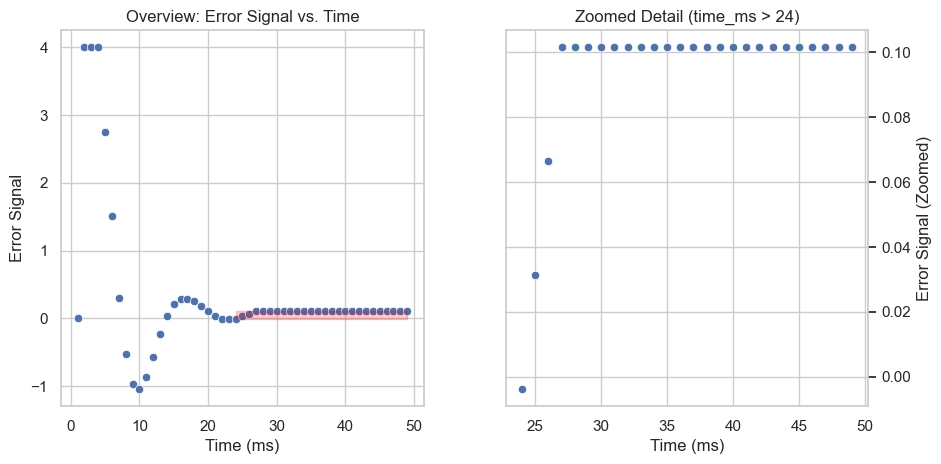

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches # For drawing the rectangle

sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=False)
sns.scatterplot(dfp, x='time_ms',y='error_signal',ax=axes[0])
sns.scatterplot(dfp.filter(pl.col('time_ms') > 24), x='time_ms',y='error_signal',ax=axes[1])
#fig.suptitle('Error Signal Analysis: Overview and Zoomed Detail', fontsize=12)
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust rect for suptitle

# Define rectangle parameters
rect_x = 24
rect_width = overview_data_pd['time_ms'].max() - zoom_x_start # Or axes[0].get_xlim()[1] - zoom_x_start
rect_y_min_on_overview, rect_y_max_on_overview = axes[1].get_ylim()
rect = patches.Rectangle(
        (rect_x, rect_y_min_on_overview), # (x,y) bottom-left
        rect_width,            # width
        rect_y_max_on_overview - rect_y_min_on_overview, # height
        linewidth=1,
        edgecolor='red',
        facecolor='red',
        alpha=0.2, # Slight transparency
        label='Zoomed Region' # For legend, if desired
    )
axes[0].set_title('Overview: Error Signal vs. Time')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Error Signal')
axes[0].add_patch(rect)
axes[1].yaxis.tick_right()
axes[1].set_xlabel('Time (ms)')
axes[1].yaxis.set_label_position("right")
axes[1].set_ylabel('Error Signal (Zoomed)') 
axes[1].set_title(f'Zoomed Detail (time_ms > {zoom_x_start})')